## Disimpy tutorial

This tutorial shows how to synthesize diffusion MRI data using disimpy.

In [1]:
# Import modules used in this tutorial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from disimpy import simulations, gradients, utils

### Free diffusion

Initiating simulation. Step length = 3.11E-06
Simulation finished.


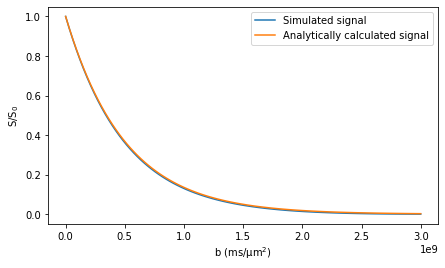

In [2]:
# Define simulation parameters

n_s = int(1e4)  # Number of random walkers
n_t = int(1e2)  # Number of time points
diffusivity = 2e-9  # In SI units (m^2/s)


# Define gradient array.

# Gradient arrays are numpy arrays of shape (number of measurements, number of
# time points, 3), where the last axis represents the cartesian coordinates of
# the laboratory frame of reference. The elements of the gradient array
# represent the magnitude of the diffusion encoding magnetic field gradient in
# SI units (T/m).

bs = np.linspace(1, 3e9, 100)  # b-values in SI units (s/m^2)
gradient_file = 'disimpy/tests/example_gradient.txt'
gradient = np.loadtxt(gradient_file)[np.newaxis, :, :]
gradient = np.concatenate([gradient for _ in bs], axis=0)
T = 80e-3  # Duration of gradient array in seconds
dt = T / (gradient.shape[1] - 1)  # Duration of time step in gradient array
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Define substrate and run simulation

# The simulated diffusion environment is referred to as substrate, which is
# defined using a dictionary. For free diffusion, it is simply

substrate = {'type' : 'free'}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot the simulated signal alongside analytically calculated signal

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, signals / n_s)
ax.plot(bs, np.exp(-bs * diffusivity))
ax.legend(['Simulated signal',
           'Analytically calculated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Diffusion in a sphere

Initiating simulation. Step length = 3.11E-06
Simulation finished.


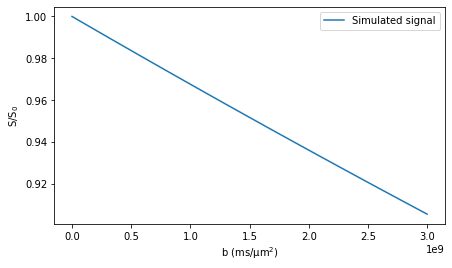

In [3]:
# Diffusion inside a sphere can be simulated by defining a substrate dictionary
# for the sphere as

substrate = {'type' : 'sphere',
             'radius' : 5e-6}


# Run simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot signal decay

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, signals/n_s)
ax.legend(['Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Diffusion in an ellipsoid

Initiating simulation. Step length = 3.11E-06
Simulation finished.


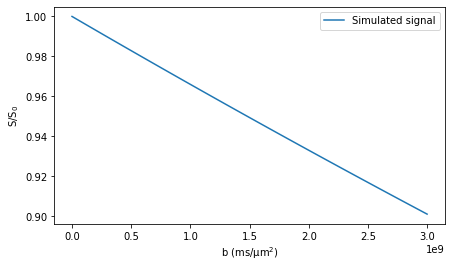

In [4]:
# Diffusion inside an ellipsoid requires the definition of the lengths of the
# principal semi-axes of the ellipsoid (a, b, c) and the rotation matrix R that
# defines how the ellipsoid is rotated before the simulation. The initial
# orientation of the ellipsoid is axis aligned with the pricipal semi-axes a, b,
# and c corresponding to x, y, and z axes, respectively.


# For example, let's define R as a rotation that alings v to k

v = np.array([1, 0, 0])
k = np.array([0, .5, 1])
R = utils.vec2vec_rotmat(v, k)


# Now we can define the substrate dictionary for the ellipsoid as

substrate = {'type' : 'ellipsoid',
             'a' : 20e-6,
             'b' : 5e-6,
             'c' : 5e-6,
             'R' : R}


# Run simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Show signal decay

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, signals/n_s)
ax.legend(['Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

Initiating simulation. Step length = 3.11E-06
Simulation finished.


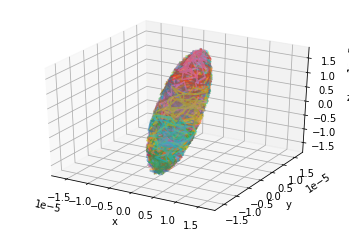

In [5]:
# The trajectories of the individual random walkers can be saved by defining the
# name of the file in which the trajectories will be saved with the trajectories
# parameter. Let's use a lower number of walkers so that the resulting file
# won't be too large.

signals = simulations.simulation(int(1e2), diffusivity, gradient, dt, substrate,
                                 trajectories='example_traj.txt')


# The trajectories can be visualized using the following function

fig, ax = utils.show_traj('example_traj.txt')
plt.show()

### Diffusion in an infinite cylinder

Initiating simulation. Step length = 6.95E-07
Simulation finished.


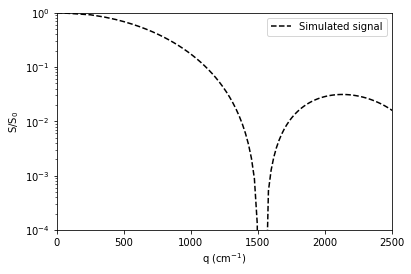

In [8]:
# This example may take a few minutes (or more) to run depending on your GPU

# In this example, let's recreate the diffraction pattern reported in Figure 2A
# in "Three-dimensional water diffusion in impermeable cylindrical tubes: theory
# versus experiments" by Avram et al., 2008.


# Diffusion inside an infinite cylinder can be simulated using the following
# substrate dictionary

substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1]),  # Orientation of the cylinder
             'radius' : 4.5e-6}


# Let's increase the number of walkers and time points to obtain better
# convergence

n_s = int(1e5)  # Number of random walkers
n_t = int(1e4)  # Number of time points


# Define gradient array with Δ = 400 ms, δ = 3 ms

bs = np.linspace(1, 1e12, 100) # b-values
delta = 3e-3
DELTA = 400e-3
T = DELTA + delta
gradient = np.zeros((1, 4030, 3))
gradient[0, 1:29, 0] = 1
gradient[0, 4001:4029, 0] = -1
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)
delta = np.sum(gradient[-1, :, :] > 0) * dt
DELTA = np.min(np.where(gradient[-1, :, 0]<0)) * dt
q = gradients.calc_q(gradient, dt)
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Run simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot signal decay

fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(qs * 1e-2 / (2 * np.pi), signals/n_s, ls='--', color='black')
ax.legend(['Simulated signal'])
ax.set_xlabel('q (cm$^{-1}$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
ax.set_ylim([1e-4, 1])
ax.set_xlim([0, 2500])
plt.show()

### Diffusion inside a triangular mesh

In [7]:
# To be implemented later